# Machine Learning for String Field Theory

H. Erbin, R. Finotello, M. Kudrna, M. Schnabl

---
---

## Abstract

In the framework of bosonic Open String Field Theory (OSFT), we consider several observables characterised by conformal weight and type, and the position of vacua in the potential for various values of truncated mass level. We focus on the prediction of the extrapolated value for the level-$\infty$ truncation using Machine Learning (ML) techniques.

## Synopsis

In this notebook we use the model independent dataset and use the *stacking* ensemble learning to improve the precision of the predictions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf

# set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        pass

In [3]:
import os
import logging

# set less logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [4]:
import numpy as np
import tensorflow as tf

RAND = 123
np.random.seed(RAND)
tf.random.set_seed(RAND)

## Training and Test Sets

In this case we will use the training set split into two subsets.
We will then use SVR, GBDT and ANN on the first fold and generate the predictions on the second fold.
We finally use a linear model on the second fold as *meta learner*.
Since we also wish to run some optimisation analysis on the first fold, we use also a cross-validation approach on the first fold.

In [5]:
import pandas as pd

X_train = pd.read_csv('./data/X_train_cv.csv')
X_test  = pd.read_csv('./data/X_test.csv')

y_train = pd.read_csv('./data/y_train_cv.csv')
y_test  = pd.read_csv('./data/y_test.csv')

In [6]:
from sklearn.model_selection import train_test_split

# split the training set into two levels
X_train_lv1, X_train_lv2, y_train_lv1, y_train_lv2 = train_test_split(X_train,
                                                                      y_train,
                                                                      train_size=0.5,
                                                                      shuffle=True,
                                                                      random_state=RAND
                                                                     )

X_train_lv1.to_csv('./data/X_train_lv1.csv', index=False)
X_train_lv2.to_csv('./data/X_train_lv2.csv', index=False)
y_train_lv1.to_csv('./data/y_train_lv1.csv', index=False)
y_train_lv2.to_csv('./data/y_train_lv2.csv', index=False)

## Training and Optimisation (First Level)

We then train the first level algorithms.

### Shallow Learning

We first consider linear regression, SVR and GBDT training using the *Scikit-learn* interface.

In [7]:
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from skopt.space import Categorical, Integer, Real
import joblib

ridge = Ridge(random_state=RAND)
svr   = SVR(kernel='rbf')
gbdt  = LGBMRegressor(boosting_type='gbdt',
                      objective='regression',
                      subsample_freq=1,
                      n_jobs=-1,
                      importance_type='gain'
                     )

rdg_space = {'estimator__alpha':         Real(1.0e-3, 1.0e1, prior='log-uniform'),
             'estimator__fit_intercept': Integer(0, 1),
             'estimator__normalize':     Integer(0, 1)
            }

svr_space = {'estimator__C':       Real(1.0e-4, 1.0e2, prior='log-uniform'),
             'estimator__epsilon': Real(0.0, 10.0),
             'estimator__gamma':   Real(1.0e-4, 1.0e1, prior='log-uniform'),
            }

gbdt_space = {'estimator__num_leaves':       Integer(2, 50),
              'estimator__max_depth':        Integer(2, 25),
              'estimator__learning_rate':    Real(1e-3, 1e-1, prior='log-uniform'),
              'estimator__n_estimators':     Integer(1e2, 5e4, prior='log-uniform'),
              'estimator__subsample':        Real(0.1, 0.99),
              'estimator__colsample_bytree': Real(0.7, 1.0),
              'estimator__min_child_weight': Real(1.0e-3, 1.0e-1, prior='log-uniform'),
              'estimator__reg_alpha':        Real(1.0e0, 1.0e2, prior='log-uniform'),
              'estimator__reg_lambda':       Real(1.0e0, 1.0e3, prior='log-uniform'),
             }

# save everything
joblib.dump(MultiOutputRegressor(ridge, n_jobs=-1), './models/ridge_lv1.pkl')
joblib.dump(MultiOutputRegressor(svr, n_jobs=-1), './models/svr_lv1.pkl')
joblib.dump(MultiOutputRegressor(gbdt, n_jobs=-1), './models/gbdt_lv1.pkl')

joblib.dump(rdg_space, './models/ridge_lv1_hypers.pkl')
joblib.dump(svr_space, './models/svr_lv1_hypers.pkl')
joblib.dump(gbdt_space, './models/gbdt_lv1_hypers.pkl')

['./models/gbdt_lv1_hypers.pkl']

In [8]:
!python3 ./scripts/multiout-cv.py -t './data/X_train_lv1.csv' -l './data/y_train_lv1.csv' \
                                  -e './models/ridge_lv1.pkl' -p './models/ridge_lv1_hypers.pkl' \
                                  -cv 5 -n 50 -r {RAND}
!python3 ./scripts/multiout-cv.py -t './data/X_train_lv1.csv' -l './data/y_train_lv1.csv' \
                                  -e './models/svr_lv1.pkl' -p './models/svr_lv1_hypers.pkl' \
                                  -cv 5 -n 50 -r {RAND}
!python3 ./scripts/multiout-cv.py -t './data/X_train_lv1.csv' -l './data/y_train_lv1.csv' \
                                  -e './models/gbdt_lv1.pkl' -p './models/gbdt_lv1_hypers.pkl' \
                                  -cv 5 -n 50 -r {RAND}

/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: Th

In [9]:
import json
import re

with open('./models/ridge_lv1_hypers.json') as f:
    ridge = json.load(f)
    
ridge = pd.DataFrame(ridge, index=['ridge']).rename(columns=lambda c: re.sub('estimator__', '', c))
print('Ridge -- best hyperparameters: ')
ridge

Ridge -- best hyperparameters: 


,alpha,fit_intercept,normalize
ridge,0.044597,1,1


In [10]:
import json
import re

with open('./models/svr_lv1_hypers.json') as f:
    svr = json.load(f)
    
svr = pd.DataFrame(svr, index=['svr']).rename(columns=lambda c: re.sub('estimator__', '', c))
print('SVR -- best hyperparameters: ')
svr

SVR -- best hyperparameters: 


,C,epsilon,gamma
svr,100.0,0.0,10.0


In [11]:
import json
import re

with open('./models/gbdt_lv1_hypers.json') as f:
    gbdt = json.load(f)
    
gbdt = pd.DataFrame(gbdt, index=['gbdt']).rename(columns=lambda c: re.sub('estimator__', '', c))
print('GBDT -- best hyperparameters: ')
gbdt

GBDT -- best hyperparameters: 


,colsample_bytree,learning_rate,max_depth,min_child_weight,n_estimators,num_leaves,reg_alpha,reg_lambda,subsample
gbdt,0.7,0.1,25,0.001,24777,50,1.0,1000.0,0.99


We then make the predictions on the second level set and the test set:

In [12]:
!python3 ./scripts/multiout-predict.py -t './data/X_train_lv2.csv' -l './data/y_train_lv2.csv' -e './models/ridge_lv1.pkl' -o 'ridge_lv2'
!python3 ./scripts/multiout-predict.py -t './data/X_train_lv2.csv' -l './data/y_train_lv2.csv' -e './models/svr_lv1.pkl' -o 'svr_lv2'
!python3 ./scripts/multiout-predict.py -t './data/X_train_lv2.csv' -l './data/y_train_lv2.csv' -e './models/gbdt_lv1.pkl' -o 'gbdt_lv2'

MultiOutputRegressor predicted in 0.292 seconds.
MultiOutputRegressor predicted in 0.305 seconds.
MultiOutputRegressor predicted in 0.562 seconds.


In [13]:
import pandas as pd
pd.read_json('./metrics/ridge_lv2.json').set_index(pd.Index(['Re(exp)', 'Im(exp)']))

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
Re(exp),1062,0.048683,0.043810,0.053556,0.220643,0.182761,0.106247
Im(exp),1062,0.018551,0.016138,0.020965,0.136204,0.067464,-0.003830


In [14]:
import pandas as pd
pd.read_json('./metrics/svr_lv2.json').set_index(pd.Index(['Re(exp)', 'Im(exp)']))

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
Re(exp),1062,0.014396,0.008877,0.019915,0.119983,0.042343,0.735714
Im(exp),1062,0.002807,0.000733,0.004880,0.052979,0.011769,0.848126


In [15]:
import pandas as pd
pd.read_json('./metrics/gbdt_lv2.json').set_index(pd.Index(['Re(exp)', 'Im(exp)']))

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
Re(exp),1062,0.005694,0.003763,0.007624,0.075456,0.035395,0.895475
Im(exp),1062,0.002947,0.001408,0.004485,0.054282,0.017603,0.840559


In [16]:
!python3 ./scripts/multiout-predict.py -t './data/X_test.csv' -l './data/y_test.csv' -e './models/ridge_lv1.pkl' -o 'ridge_stack_test'
!python3 ./scripts/multiout-predict.py -t './data/X_test.csv' -l './data/y_test.csv' -e './models/svr_lv1.pkl' -o 'svr_stack_test'
!python3 ./scripts/multiout-predict.py -t './data/X_test.csv' -l './data/y_test.csv' -e './models/gbdt_lv1.pkl' -o 'gbdt_stack_test'

MultiOutputRegressor predicted in 0.288 seconds.
MultiOutputRegressor predicted in 0.292 seconds.
MultiOutputRegressor predicted in 0.479 seconds.


In [17]:
import pandas as pd
pd.read_json('./metrics/ridge_stack_test.json').set_index(pd.Index(['Re(exp)', 'Im(exp)']))

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
Re(exp),232,0.054847,0.042973,0.066721,0.234194,0.188580,0.10031
Im(exp),232,0.018441,0.013044,0.023838,0.135798,0.064021,-0.00252


In [18]:
import pandas as pd
pd.read_json('./metrics/svr_stack_test.json').set_index(pd.Index(['Re(exp)', 'Im(exp)']))

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
Re(exp),232,0.017158,0.00667,0.027647,0.130990,0.044259,0.718540
Im(exp),232,0.000803,-0.00002,0.001626,0.028337,0.006648,0.956348


In [19]:
import pandas as pd
pd.read_json('./metrics/gbdt_stack_test.json').set_index(pd.Index(['Re(exp)', 'Im(exp)']))

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
Re(exp),232,0.009794,0.002690,0.016897,0.098963,0.040452,0.839347
Im(exp),232,0.002512,0.000777,0.004248,0.050123,0.017790,0.863421


### Deep Learning

We also make predictions using the neural network:

In [20]:
!python3 ./scripts/train.py -tx './data/X_train_lv1.csv' -ty './data/y_train_lv1.csv' \
                            -vx './data/X_train_lv2.csv' -vy './data/y_train_lv2.csv' \
                            -m './models/ann.h5' -ep 20000 -b 32 -es 1000 -pf 0.3 -pp 750 -r {RAND}

Training finished in 163.17 seconds.


In [21]:
!python3 ./scripts/predict.py -tx './data/X_train_lv2.csv' -ty './data/y_train_lv2.csv' -m './models/ann.h5' -o 'ann_lv2'
!python3 ./scripts/predict.py -tx './data/X_test.csv' -ty './data/y_test.csv' -m './models/ann.h5' -o 'ann_stack_test'

In [22]:
import pandas as pd
pd.read_csv('./data/ann_lv2_metrics.csv', index_col=0)

,exp_re,exp_im
dof,1062.000000,1062.000000
mse,0.001609,0.001267
mse_ci_low,0.000670,0.000547
mse_ci_high,0.002549,0.001986
mae,0.019269,0.014674
r2,0.970455,0.931454


In [23]:
import pandas as pd
pd.read_csv('./data/ann_stack_test_metrics.csv', index_col=0)

,exp_re,exp_im
dof,232.000000,232.000000
mse,0.011419,0.000765
mse_ci_low,0.002264,0.000256
mse_ci_high,0.020574,0.001274
mae,0.035281,0.014559
r2,0.812693,0.958412


## Meta Learner

Since all algorithms are multi output learners we need to differentiate the predictions for the real part of the extrapolations and their imaginary part.

In [24]:
import pandas as pd

ridge_lv2_pred = pd.read_csv('./predictions/ridge_lv2.csv')[['exp_re', 'exp_im']]
svr_lv2_pred   = pd.read_csv('./predictions/svr_lv2.csv')[['exp_re', 'exp_im']]
gbdt_lv2_pred  = pd.read_csv('./predictions/gbdt_lv2.csv')[['exp_re', 'exp_im']]
ann_lv2_pred   = pd.read_csv('./data/y_ann_lv2_pred.csv')[['exp_re', 'exp_im']]

# create the dataset for the real part
df_re = pd.concat([ridge_lv2_pred['exp_re'],
                   svr_lv2_pred['exp_re'],
                   gbdt_lv2_pred['exp_re'],
                   ann_lv2_pred['exp_re']
                  ],
                  axis=1
                 ).reset_index(drop=True)

# create the dataset for the imaginary part
df_im = pd.concat([ridge_lv2_pred['exp_im'],
                   svr_lv2_pred['exp_im'],
                   gbdt_lv2_pred['exp_im'],
                   ann_lv2_pred['exp_im']
                  ],
                  axis=1
                 ).reset_index(drop=True)

# save the datasets to file
df_re.to_csv('./data/X_train_meta_re.csv', index=False)
df_im.to_csv('./data/X_train_meta_im.csv', index=False)

In [25]:
import pandas as pd

ridge_test_pred = pd.read_csv('./predictions/ridge_test.csv')[['exp_re', 'exp_im']]
svr_test_pred   = pd.read_csv('./predictions/svr_test.csv')[['exp_re', 'exp_im']]
gbdt_test_pred   = pd.read_csv('./predictions/gbdt_test.csv')[['exp_re', 'exp_im']]
ann_test_pred   = pd.read_csv('./data/y_ann_test_pred.csv')[['exp_re', 'exp_im']]

# create the dataset for the real part
df_re = pd.concat([ridge_test_pred['exp_re'],
                   svr_test_pred['exp_re'],
                   gbdt_test_pred['exp_re'],
                   ann_test_pred['exp_re']
                  ],
                  axis=1
                 ).reset_index(drop=True)

# create the dataset for the imaginary part
df_im = pd.concat([ridge_test_pred['exp_im'],
                   svr_test_pred['exp_im'],
                   gbdt_test_pred['exp_im'],
                   ann_test_pred['exp_im']
                  ],
                  axis=1
                 ).reset_index(drop=True)

# save the datasets to file
df_re.to_csv('./data/X_test_meta_re.csv', index=False)
df_im.to_csv('./data/X_test_meta_im.csv', index=False)

In [26]:
import pandas as pd

# split the labels
lab_lv2  = pd.read_csv('./data/y_train_lv2.csv')
lab_test = pd.read_csv('./data/y_test.csv')

# save the labels separately
lab_lv2[['exp_re']].to_csv('./data/y_train_lv2_re.csv', index=False)
lab_lv2[['exp_im']].to_csv('./data/y_train_lv2_im.csv', index=False)

lab_test[['exp_re']].to_csv('./data/y_test_re.csv', index=False)
lab_test[['exp_im']].to_csv('./data/y_test_im.csv', index=False)

We then train two linear models on the predictions to find the real and imaginary parts:

In [27]:
from sklearn.linear_model import Ridge
from skopt.space import Real, Integer
import joblib

ridge = Ridge(random_state=RAND)
rdg_space = {'alpha':         Real(1.0e-3, 1.0e1, prior='log-uniform'),
             'fit_intercept': Integer(0, 1),
             'normalize':     Integer(0, 1)
            }

# save to file
joblib.dump(ridge, './models/ridge_meta_re.pkl')
joblib.dump(ridge, './models/ridge_meta_im.pkl')

joblib.dump(rdg_space, './models/ridge_meta_hypers_re.pkl')
joblib.dump(rdg_space, './models/ridge_meta_hypers_im.pkl')

['./models/ridge_meta_hypers_im.pkl']

In [28]:
!python3 ./scripts/multiout-cv.py -t './data/X_train_meta_re.csv' -l './data/y_train_lv2_re.csv' \
                                  -e './models/ridge_meta_re.pkl' -p './models/ridge_meta_hypers_re.pkl' \
                                  -cv 5 -n 50 -r {RAND}
!python3 ./scripts/multiout-cv.py -t './data/X_train_meta_im.csv' -l './data/y_train_lv2_im.csv' \
                                  -e './models/ridge_meta_im.pkl' -p './models/ridge_meta_hypers_im.pkl' \
                                  -cv 5 -n 50 -r {RAND}

/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
BayesSearchCV trained in 28.749 seconds.
/home/riccardo/conda/envs/ml-sft-trunc/lib/python3.7/site-packages/skopt/op

In [29]:
import json
import re

with open('./models/ridge_meta_hypers_re.json') as f:
    ridge_re = json.load(f)
    
ridge_re = pd.DataFrame(ridge_re, index=['ridge_re']).rename(columns=lambda c: re.sub('estimator__', '', c))
print('Ridge Re(exp) -- best hyperparameters: ')
ridge_re

Ridge Re(exp) -- best hyperparameters: 


,alpha,fit_intercept,normalize
ridge_re,0.044068,0,1


In [30]:
import json
import re

with open('./models/ridge_meta_hypers_im.json') as f:
    ridge_im = json.load(f)
    
ridge_im = pd.DataFrame(ridge_im, index=['ridge_im']).rename(columns=lambda c: re.sub('estimator__', '', c))
print('Ridge Im(exp) -- best hyperparameters: ')
ridge_im

Ridge Im(exp) -- best hyperparameters: 


,alpha,fit_intercept,normalize
ridge_im,0.178016,0,0


We finally compute the predictions on the test set.

In [31]:
import pandas as pd
import joblib

# load the trained estimators
meta_re = joblib.load('./models/ridge_meta_re.pkl')
meta_im = joblib.load('./models/ridge_meta_im.pkl')

# load the datasets
X_test_re = pd.read_csv('./data/X_test_meta_re.csv')
X_test_im = pd.read_csv('./data/X_test_meta_im.csv')

y_test_re = pd.read_csv('./data/y_test_re.csv')
y_test_im = pd.read_csv('./data/y_test_im.csv')

# compute the predictions
y_test_re_pred = pd.DataFrame(meta_re.predict(X_test_re), columns=['exp_re_pred'])
y_test_im_pred = pd.DataFrame(meta_im.predict(X_test_im), columns=['exp_im_pred'])

# save the predictions to file
y_test_re_pred.to_csv('./predictions/y_test_re_pred.csv', index=False)
y_test_im_pred.to_csv('./predictions/y_test_im_pred.csv', index=False)

We finally plot the predictions and compute the metrics:

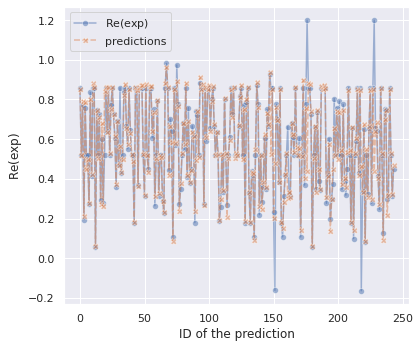

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.lineplot(data=pd.concat([y_test_re, y_test_re_pred], axis=0),
             alpha=0.5,
             markers=True,
             ax=ax
            )
ax.set(title='',
       xlabel='ID of the prediction',
       ylabel='$\mathrm{Re}(\mathrm{exp})$'
      )
ax.legend(['$\mathrm{Re}(\mathrm{exp})$', 'predictions'], loc='best')

plt.tight_layout()
plt.savefig('./img/meta_exp_re_plot.pdf', dpi=150, format='pdf')
plt.savefig('./img/meta_exp_re_plot.png', dpi=150, format='png')

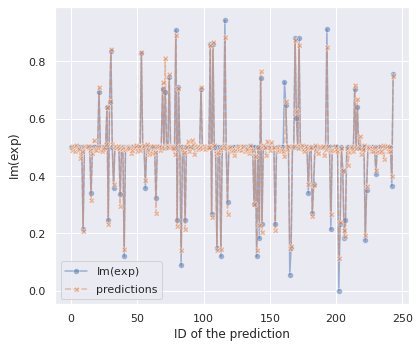

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.lineplot(data=pd.concat([y_test_im, y_test_im_pred], axis=0),
             alpha=0.5,
             markers=True,
             ax=ax
            )
ax.set(title='',
       xlabel='ID of the prediction',
       ylabel='$\mathrm{Im}(\mathrm{exp})$'
      )
ax.legend(['$\mathrm{Im}(\mathrm{exp})$', 'predictions'], loc='best')

plt.tight_layout()
plt.savefig('./img/meta_exp_im_plot.pdf', dpi=150, format='pdf')
plt.savefig('./img/meta_exp_im_plot.png', dpi=150, format='png')

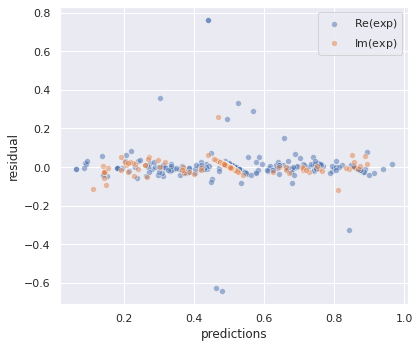

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

_, ax = plt.subplots(1, 1, figsize=(6,5))

sns.scatterplot(x=y_test_re_pred.values.reshape(-1,),
                y=(y_test_re.values - y_test_re_pred.values).reshape(-1,),
                alpha=0.5,
                ax=ax
               )
sns.scatterplot(x=y_test_im_pred.values.reshape(-1,),
                y=(y_test_im.values - y_test_im_pred.values).reshape(-1,),
                alpha=0.5,
                ax=ax
               )
ax.set(title='',
       xlabel='predictions',
       ylabel='residual'
      )
ax.legend(['$\mathrm{Re}(\mathrm{exp})$', '$\mathrm{Im}(\mathrm{exp})$'])

plt.tight_layout()
plt.savefig('./img/meta_res_plot.pdf', dpi=150, format='pdf')
plt.savefig('./img/meta_res_plot.png', dpi=150, format='png')

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print('\nReal part:')
mse_re = mean_squared_error(y_test_re.values.reshape(-1,), y_test_re_pred.values.reshape(-1,))
mae_re = mean_absolute_error(y_test_re.values.reshape(-1,), y_test_re_pred.values.reshape(-1,))
r2_re  = r2_score(y_test_re.values.reshape(-1,), y_test_re_pred.values.reshape(-1,))

print(f'  MSE: {mse_re:.4f}')
print(f'  MAE: {mae_re:.4f}')
print(f'  R2:  {r2_re:.4f}')

print('\nImaginary part:')
mse_im = mean_squared_error(y_test_im.values.reshape(-1,), y_test_im_pred.values.reshape(-1,))
mae_im = mean_absolute_error(y_test_im.values.reshape(-1,), y_test_im_pred.values.reshape(-1,))
r2_im  = r2_score(y_test_im.values.reshape(-1,), y_test_im_pred.values.reshape(-1,))

print(f'  MSE: {mse_im:.4f}')
print(f'  MAE: {mae_im:.4f}')
print(f'  R2:  {r2_im:.4f}')


Real part:
  MSE: 0.0107
  MAE: 0.0346
  R2:  0.8246

Imaginary part:
  MSE: 0.0007
  MAE: 0.0135
  R2:  0.9629
